In [1]:
from feedback_grape.utils.operators import (
    sigmax,
    sigmay,
    sigmaz,
)
from feedback_grape.utils.states import basis
from feedback_grape.utils.tensor import tensor
from feedback_grape.utils.fidelity import fidelity
import jax
from jax import numpy as jnp
from library.utils.qubit_chain_1D import embed
from library.utils.plot_matrix import plot_matrix
from tqdm import tqdm
from jax.scipy.linalg import expm
import numpy as np
import json
import numpy as np
from time import time

# Wrote this for open boundaries and J_x, J_y couplings between neighboring qubits and X rotation on last qubit
h    = 1.0 # Transverse field strength
beta = 1.0 # Inverse temperature
table_dir = "lookup_tables/test_lookup_table.json" # Path to lookup table json file

def initialize_thermal_state(n):
    H = sum([-h*embed(sigmaz(), i, n) for i in range(n)]) # System Hamiltonian, transverse field term

    eigenvals, eigenvecs = jnp.linalg.eigh(H) # Energy eigenvalues and eigenstates

    # Initial thermal state
    Z = jnp.sum(jnp.exp(-beta * eigenvals))
    rho_thermal = sum((jnp.exp(-beta * eigenvals[i]) / Z) * jnp.outer(eigenvecs[:, i], jnp.conj(eigenvecs[:, i])) for i in range(len(eigenvals)))
    rho_thermal = rho_thermal / jnp.trace(rho_thermal) # Normalize

    return rho_thermal

def initialize_random_state(key, n):
    rho = jax.random.normal(key, (2**n,2**n)) + 1j * jax.random.normal(key, (2**n,2**n))
    rho = rho + rho.conj().T # Make Hermitian
    rho = rho / jnp.trace(rho) # Normalize
    return rho

def initialize_ground_state(n):
    return basis(2**n, 0)@basis(2**n, 0).conj().T # All spins down

# Import lookup table from json file
with open(table_dir, 'r') as f:
    lookup_table = json.load(f)["lookup_table"]
    t_trained = len(lookup_table) # Number of time steps the network was trained on
n_trained = 3 # Number of qubits the network was trained on, hardcoded here

print("loaded lookup table for", n_trained, "qubits and", t_trained, "time steps")

# Control operators (X,Y interaction between neighboring qubits and X rotation on last qubit which is the minimum control set to achieve full controllability)
# Measurement operator (projective measurement along z-axis on first qubit)
def projection_measurement_operator(measurement_outcome, n):
    return jnp.where(
        measurement_outcome == 1,
        tensor(jnp.eye(2**(n-1)), basis(2, 0)@basis(2, 0).conj().T),
        tensor(jnp.eye(2**(n-1)), basis(2, 1)@basis(2, 1).conj().T),
    )
    
def unitary_op(params, n):
    transport_params = params[1:]
    rotation_params  = params[0]

    def transport_unitary(params):
        J_x, J_y = params
        return expm(-1j*sum([
            -0.5*J_x*embed(sigmax(), i, n)@embed(sigmax(), i+1, n)
            -0.5*J_y*embed(sigmay(), i, n)@embed(sigmay(), i+1, n)
            for i in range(n-1)
        ]))

    def rotation_unitary(params):
        alpha = params
        return expm(-1j*embed(sigmax(), n-1, n)*alpha) # Local X rotation on last qubit

    return transport_unitary(transport_params) @ rotation_unitary(rotation_params)

def calculate_expected_fidelity(lookup_table, n, t, rho_initial, rho_target):
    rho_initial = jnp.array(rho_initial)
    rho_target  = jnp.array(rho_target)
    t_trained = len(lookup_table)
    fidelity_history  = [0]*t

    # Pre-evaluate unitary and measurement operators for efficiency
    def _evaluate_msmt_op(meas, n):
        return jnp.array(projection_measurement_operator(meas, n))
    
    M_ops = [_evaluate_msmt_op(meas, n) for meas in [1, -1]]

    # Jit some of the most inner functions for efficiency
    _fidelity_jit = jax.jit(lambda U_final: fidelity(C_target=rho_target, U_final=U_final, evo_type="density"))

    def _apply_operators(rho, U, M):
        rho_new = M @ rho @ M.conj().T
        P = jnp.real(jnp.trace(rho_new))
        rho_new = U @ (rho_new / P) @ U.conj().T
        return rho_new, P
    
    compiled_ops = [None]*(2**t_trained)
    for history in range(2**t_trained):
        U = jnp.array(unitary_op(lookup_table[t_trained-1][history], n))
        M = M_ops[history & 1]

        compiled_ops[history] = jax.jit(lambda rho: _apply_operators(rho, U, M))
        compiled_ops[history](rho_initial) # Run once to compile and write U and M into the function
    
    # Recursive function to calculate all trajectories
    def _calculate_timestep(rho, t_now, history):
        if t_now < t_trained:
            row = t_now
        else:
            row = t_trained - 1

        history = (history << 1) & ((1 << t_trained) - 1) # Keep only last t_trained bits
        for idx in range(0, 2):
            if t_now < t_trained:
                U = unitary_op(lookup_table[row][history], n)
                M = M_ops[idx]
                rho_new, P = _apply_operators(rho, U, M)
            else:
                rho_new, P = compiled_ops[history](rho)

            fidelity_history[t_now] += P*_fidelity_jit(rho_new)

            if t_now < t - 1:
                _calculate_timestep(
                    rho_new,
                    t_now + 1,
                    history,
                )
            
            history += 1 # Change last bit to 1 for next iteration
    
    _calculate_timestep(rho_initial, 0, 0)

    # Normalize by number of branches
    for i in range(t):
        fidelity_history[i] /= 2**i
    return jnp.array(fidelity_history)

loaded lookup table for 3 qubits and 2 time steps


In [5]:
# Calculate fidelities for 10 random initial states using jax.vmap
n_arr = np.arange(2, 5) # Number of qubits to test
t_max = 20 # Number of time steps to test
use_thermal_state = False # If True, use thermal initial state, otherwise use *N_random* random initial states
N_random = 100
do_save = True # If True, save resulting plot and data

if not use_thermal_state:
    print("Using random initial states")
    keys = jax.random.split(jax.random.PRNGKey(42), num=N_random)
    def fidelity_for_key(key):
        fidelities = jnp.zeros((len(n_arr), t_max))

        start = time()
        for i, n in enumerate(n_arr):
            print(f"Calculating for {n} qubits")
            key, subkey = jax.random.split(key)
            rho_initial = initialize_random_state(subkey, n)
            rho_target   = initialize_ground_state(n)
            fidelity_iter = calculate_expected_fidelity(lookup_table, n, t_max, rho_initial, rho_target)
            fidelities = fidelities.at[i, :].set(jnp.array(fidelity_iter))

            # Print how long it took to calculate
            print(f"Duration for {n} qubits: {time() - start:.2f} seconds")
            start = time()

        return jnp.array(fidelities)

    fidelity_results = jax.vmap(fidelity_for_key)(keys)
    fidelities = jnp.mean(fidelity_results, axis=0)
else:
    print("Using thermal initial state")
    fidelities = np.zeros((len(n_arr), t_max))

    start = time()
    for i, n in enumerate(n_arr):
        print(f"Calculating for {n} qubits")
        
        rho_initial = initialize_thermal_state(n)
        rho_target   = initialize_ground_state(n)
        fidelity_iter = calculate_expected_fidelity(lookup_table, n, t_max, rho_initial, rho_target)
        fidelities[i, :] = np.array(fidelity_iter)

        # Print how long it took to calculate
        print(f"Duration for {n} qubits: {time() - start:.2f} seconds")
        start = time()

Using random initial states
Calculating for 2 qubits
Duration for 2 qubits: 584.00 seconds
Calculating for 3 qubits
Duration for 3 qubits: 729.33 seconds
Calculating for 4 qubits
Duration for 4 qubits: 2021.34 seconds


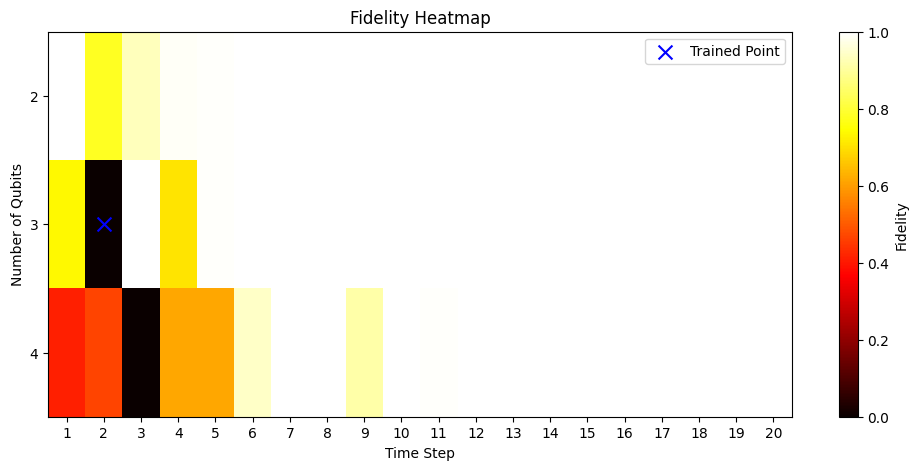

In [7]:
# Plot fidelities in 2d heatmap
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(12,5))
cmap = plt.get_cmap('hot')
cax = ax.imshow(fidelities, aspect='auto', cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(cax, label='Fidelity', extend='neither')
ax.set_xlabel('Time Step')
ax.set_ylabel('Number of Qubits')
ax.set_title('Fidelity Heatmap')
ax.set_xticks(ticks=np.arange(t_max))
ax.set_xticklabels(np.arange(1, t_max+1))
ax.set_yticks(ticks=np.arange(len(n_arr)))
ax.set_yticklabels(n_arr)

# Mark the trained point
if n_trained in n_arr and t_trained <= t_max:
    trained_n_index = np.where(n_arr == n_trained)[0][0]
    ax.scatter(t_trained - 1, trained_n_index, color='blue', s=100, label='Trained Point', marker='x')
    ax.legend()
    
plt.show()

if do_save:
    fig.savefig(f"fidelity_heatmap_tmax={t_max}_nmax={max(n_arr)}_thermal={use_thermal_state}_N={N_random}.png", dpi=300)
    np.save(f"fidelity_heatmap_tmax={t_max}_nmax={max(n_arr)}_thermal={use_thermal_state}_N={N_random}.npy", fidelities)
